In [1]:
import cv2
import numpy as np
import os
import random

def split_image(image, num_rows, num_cols):
    """Split the image into num_rows x num_cols pieces."""
    height, width, _ = image.shape
    pieces = []
    h_step = height // num_rows
    w_step = width // num_cols

    for i in range(num_rows):
        for j in range(num_cols):
            y1 = i * h_step
            y2 = (i + 1) * h_step
            x1 = j * w_step
            x2 = (j + 1) * w_step
            piece = image[y1:y2, x1:x2]
            pieces.append(piece)

    return pieces

def augment_image(image):
    """Apply various augmentations to the image."""
    # Flip horizontally
    if random.random() > 0.5:
        image = cv2.flip(image, 1)
    
    # Flip vertically
    if random.random() > 0.5:
        image = cv2.flip(image, 0)
    
    # Rotate
    angle = random.randint(-30, 30)
    height, width = image.shape[:2]
    M = cv2.getRotationMatrix2D((width/2, height/2), angle, 1)
    image = cv2.warpAffine(image, M, (width, height))
    
    # Brightness adjustment
    alpha = random.uniform(0.5, 1.5)
    image = cv2.multiply(image, np.array([alpha]))

    # Gaussian blur
    if random.random() > 0.5:
        image = cv2.GaussianBlur(image, (5, 5), 0)

    return image

def save_images(images, directory, num_images):
    """Save the augmented images to the specified directory."""
    os.makedirs(directory, exist_ok=True)
    
    for i in range(num_images):
        image = images[random.randint(0, len(images) - 1)]
        filename = os.path.join(directory, f"augmented_image_{i}.jpg")
        cv2.imwrite(filename, image)

def main(path_to_image, path_to_image_directory, num_rows, num_cols, num_images):
    # Load the image
    image = cv2.imread(path_to_image)
    
    # Split the image into pieces
    pieces = split_image(image, num_rows, num_cols)
    
    # Augment each piece
    augmented_images = [augment_image(piece) for piece in pieces]
    
    # Save the augmented images
    save_images(augmented_images, path_to_image_directory, num_images)

if __name__ == "__main__":
    path_to_image = "istockphoto-1486944969-612x612.jpg"
    path_to_image_directory = "path_to_image_directory"
    num_rows = 2
    num_cols = 2
    num_images = 25
    
    main(path_to_image, path_to_image_directory, num_rows, num_cols, num_images)


In [4]:
import cv2
import os

def find_keypoints(image_path, max_keypoints):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    orb = cv2.ORB_create()
    
    keypoints, descriptors = orb.detectAndCompute(img, None)
    
    keypoints = sorted(keypoints, key=lambda x: -x.response)[:max_keypoints]
    
    img_with_keypoints = cv2.drawKeypoints(img, keypoints, None, flags=cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS)
    
    return keypoints, img_with_keypoints

def save_keypoints_images(input_dir, output_dir, max_keypoints):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    image_files = [f for f in os.listdir(input_dir) if os.path.isfile(os.path.join(input_dir, f))]
    
    for image_file in image_files:
        image_path = os.path.join(input_dir, image_file)
        
        keypoints, img_with_keypoints = find_keypoints(image_path, max_keypoints)
        
        output_file = os.path.join(output_dir, image_file)
        cv2.imwrite(output_file, img_with_keypoints)
        
        keypoints_file = os.path.splitext(output_file)[0] + '.txt'
        with open(keypoints_file, 'w') as f:
            for kp in keypoints:
                f.write(f"{kp.pt[0]} {kp.pt[1]}\n")

input_dir = 'path_to_image_directory'  
output_dir = 'path_to_label_directory'  

max_keypoints = 15

save_keypoints_images(input_dir, output_dir, max_keypoints)


In [5]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

class CustomDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.images, self.labels = self.load_images_and_labels()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            img = self.transform(img)
        
        return img, label

    def load_images_and_labels(self):
        images = []
        labels = []
        
        for filename in os.listdir(self.image_dir):
            if filename.endswith('.jpg') or filename.endswith('.png'):
                # Загрузка изображения
                img_path = os.path.join(self.image_dir, filename)
                img = cv2.imread(img_path)
                
                # Загрузка меток
                label_path = os.path.join(self.label_dir, filename.replace('.jpg', '.txt').replace('.png', '.txt'))
                with open(label_path, 'r') as file:
                    lines = file.readlines()
                    points = [list(map(float, line.strip().split())) for line in lines]
                
                images.append(img)
                labels.append(points)
                
        return images, labels

def preprocess_image(img):
    img = cv2.resize(img, (256, 256))
    img = img.astype(np.float32) / 255.0
    img = np.transpose(img, (2, 0, 1))  # Преобразование порядка каналов для PyTorch (C, H, W)
    return torch.tensor(img)

def preprocess_labels(labels, original_shape, target_shape):
    original_height, original_width = original_shape
    target_height, target_width = target_shape
    
    scale_x = target_width / original_width
    scale_y = target_height / original_height
    
    preprocessed_labels = []
    num_keypoints = len(labels[0])  # Определение количества ключевых точек для первого изображения
    
    for points in labels:
        # Решейп меток для каждого изображения
        points = np.array(points)
        points = points.reshape(-1)
        
        scaled_points = [point * scale_x if i % 2 == 0 else point * scale_y for i, point in enumerate(points)]
        
        # Дополнение нулями до максимального количества ключевых точек
        scaled_points += [0.0] * ((num_keypoints * 2) - len(scaled_points))
        
        preprocessed_labels.append(scaled_points)
        
    return torch.tensor(preprocessed_labels)


# Директории с изображениями и метками
image_dir = 'path_to_image_directory'
label_dir = 'path_to_label_directory'

dataset = CustomDataset(image_dir, label_dir, transform=preprocess_image)

class KeypointDetectionModel(nn.Module):
    def __init__(self, num_keypoints=3):
        super(KeypointDetectionModel, self).__init__()

        self.num_keypoints = num_keypoints
        
        # Свёрточные слои
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        
        # Полносвязные слои
        self.fc1 = nn.Linear(128, 1024)
        self.fc2 = nn.Linear(1024, self.num_keypoints * 2)  # num_keypoints * 2, так как для каждой точки две координаты (x, y)
        
    def forward(self, x):
        # Прямой проход через свёрточные слои
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        
        # Global Average Pooling
        x = F.adaptive_avg_pool2d(x, (1, 1))
        
        # Решейп для полносвязных слоёв
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        # Решейп для представления ключевых точек
        x = x.view(x.size(0), self.num_keypoints, 2)
        
        return x

# Создание экземпляра модели
model = KeypointDetectionModel(num_keypoints=15)

# Определение функции потерь и оптимизатора
criterion = nn.MSELoss()  # Квадратичная функция потерь для задачи регрессии
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [6]:
dataset.labels

[[[140.0, 263.0],
  [143.0, 261.0],
  [140.40000915527344, 262.8000183105469],
  [144.0, 261.6000061035156],
  [147.0, 44.0],
  [104.0, 33.0],
  [111.0, 38.0],
  [145.20001220703125, 43.20000076293945],
  [106.0, 33.0],
  [107.0, 36.0],
  [148.8000030517578, 46.80000305175781],
  [110.4000015258789, 38.400001525878906],
  [141.60000610351562, 38.400001525878906],
  [144.0, 258.0],
  [148.0, 253.0]],
 [[158.40000915527344, 40.80000305175781],
  [111.97442626953125, 144.32260131835938],
  [110.0, 149.0],
  [159.0, 42.0],
  [110.4000015258789, 148.8000030517578],
  [109.4861068725586, 149.2992401123047],
  [107.82721710205078, 149.29922485351562],
  [116.64000701904297, 142.5600128173828],
  [42.0, 256.8000183105469],
  [109.44000244140625, 148.32000732421875],
  [117.0, 143.0],
  [108.864013671875, 148.60801696777344],
  [35.0, 246.0],
  [115.77600860595703, 143.42401123046875],
  [40.0, 259.0]],
 [[158.40000915527344, 40.80000305175781],
  [111.97442626953125, 144.32260131835938],
  [11

In [7]:
batch_size = 1
epochs = 5

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

model.train()

for epoch in range(epochs):
    epoch_loss = 0.0
    for images, labels in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}", dynamic_ncols=True):
        optimizer.zero_grad()

        preprocessed_labels = preprocess_labels(labels, (images.shape[2], images.shape[3]), (256, 256))
        preprocessed_labels = preprocessed_labels.float()  # Преобразование к типу Float

        outputs = model(images)

        outputs = outputs.view(outputs.size(0), -1)[:,:preprocessed_labels.size(1)]
        
        loss = criterion(outputs, preprocessed_labels)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(dataloader):.4f}")

print("Всё нормик")


Epoch 1/5:   0%|          | 0/25 [00:00<?, ?it/s]d:\PYTHONLANG\Python10.6\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([15, 4])) that is different to the input size (torch.Size([1, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 1/5: 100%|██████████| 25/25 [00:01<00:00, 18.04it/s]


Epoch 1/5, Loss: 8009.7851


Epoch 2/5: 100%|██████████| 25/25 [00:01<00:00, 17.92it/s]


Epoch 2/5, Loss: 2594.2982


Epoch 3/5: 100%|██████████| 25/25 [00:01<00:00, 17.49it/s]


Epoch 3/5, Loss: 2544.1638


Epoch 4/5: 100%|██████████| 25/25 [00:01<00:00, 17.71it/s]


Epoch 4/5, Loss: 2368.4326


Epoch 5/5: 100%|██████████| 25/25 [00:01<00:00, 16.90it/s]

Epoch 5/5, Loss: 2315.6890
Всё нормик


[[ 1.7665205e+02  3.4264041e+02]
 [-2.4626752e-02  8.2985692e-02]
 [-5.9759021e-01  1.6144783e+01]
 [ 7.8778925e+00  1.5318955e+01]
 [ 4.1502964e-01  2.3024248e+01]
 [ 9.9224758e-01 -4.1458540e+00]
 [ 6.0293895e-01  1.6368710e+00]
 [ 7.9864615e-01  1.5314031e+01]
 [-7.9763503e+00 -1.0126674e+01]
 [-5.6028337e+00  6.1251326e+00]
 [ 4.6504707e+00 -2.2494400e+01]
 [-7.5506296e+00  1.3177344e+00]
 [ 2.1625718e-01 -9.6649355e-01]
 [-1.9890488e+00 -9.4653969e+00]
 [-3.3706801e+00  1.7904928e+01]]


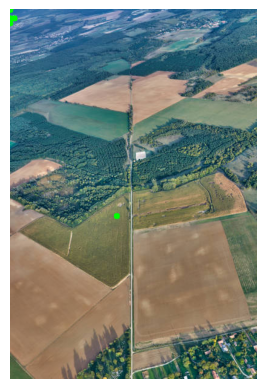

array([[ 1.7665205e+02,  3.4264041e+02],
       [-2.4626752e-02,  8.2985692e-02],
       [-5.9759021e-01,  1.6144783e+01],
       [ 7.8778925e+00,  1.5318955e+01],
       [ 4.1502964e-01,  2.3024248e+01],
       [ 9.9224758e-01, -4.1458540e+00],
       [ 6.0293895e-01,  1.6368710e+00],
       [ 7.9864615e-01,  1.5314031e+01],
       [-7.9763503e+00, -1.0126674e+01],
       [-5.6028337e+00,  6.1251326e+00],
       [ 4.6504707e+00, -2.2494400e+01],
       [-7.5506296e+00,  1.3177344e+00],
       [ 2.1625718e-01, -9.6649355e-01],
       [-1.9890488e+00, -9.4653969e+00],
       [-3.3706801e+00,  1.7904928e+01]], dtype=float32)

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def predict_keypoints(image_path, model):
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (256, 256))
    img_normalized = img_resized.astype(np.float32) / 255.0
    img_tensor = torch.tensor(img_normalized).permute(2, 0, 1).unsqueeze(0)  # Преобразование в тензор и добавление батч размерности

    model.eval()  # Установка модели в режим eval
    with torch.no_grad():
        outputs = model(img_tensor)
    
    # Решейп и преобразование предсказанных координат
    keypoints = outputs.view(-1, 2).numpy()
    keypoints[:, 0] *= img.shape[1] / 256.0  # масштабирование координат x
    keypoints[:, 1] *= img.shape[0] / 256.0  # масштабирование координат y

    print(keypoints)

    # Отображение результатов на изображении
    for x, y in keypoints:
        cv2.circle(img, (int(x), int(y)), 5, (0, 255, 0), -1)

    # Отображение и сохранение изображения с ключевыми точками
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    return keypoints


model.eval()

image_path = 'istockphoto-1486944969-612x612.jpg'

predict_keypoints(image_path, model)


[[ 1.7665205e+02  3.4264041e+02]
 [-2.4626752e-02  8.2985692e-02]
 [-5.9759021e-01  1.6144783e+01]
 [ 7.8778925e+00  1.5318955e+01]
 [ 4.1502964e-01  2.3024248e+01]
 [ 9.9224758e-01 -4.1458540e+00]
 [ 6.0293895e-01  1.6368710e+00]
 [ 7.9864615e-01  1.5314031e+01]
 [-7.9763503e+00 -1.0126674e+01]
 [-5.6028337e+00  6.1251326e+00]
 [ 4.6504707e+00 -2.2494400e+01]
 [-7.5506296e+00  1.3177344e+00]
 [ 2.1625718e-01 -9.6649355e-01]
 [-1.9890488e+00 -9.4653969e+00]
 [-3.3706801e+00  1.7904928e+01]]


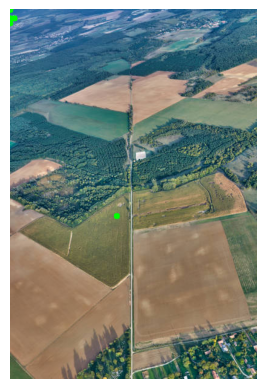

[9.99943932e-01 0.00000000e+00 4.00486992e-06 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 4.00486992e-06 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 4.00486992e-06 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 4.00486992e-06 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.00486992e-06
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 4.00486992e-06 0.000000

In [10]:
import cv2
import numpy as np

def compute_lbp(image, keypoints, radius=1, neighbors=8):
    # Конвертируем изображение в оттенки серого
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Вычисляем LBP
    lbp_image = np.zeros_like(gray_image)
    
    for point in keypoints:
        x, y = point
        lbp_value = 0
        for i in range(neighbors):
            theta = 2 * np.pi * i / neighbors
            x_i = x + radius * np.cos(theta)
            y_i = y - radius * np.sin(theta)  # Минус, потому что в изображениях ось Y направлена вниз
            x1, y1 = int(np.floor(x_i)), int(np.floor(y_i))
            x2, y2 = int(np.ceil(x_i)), int(np.ceil(y_i))
            
            # Билинейная интерполяция
            tx = x_i - x1
            ty = y_i - y1
            lbp_value <<= 1
            if gray_image[y1, x1] * (1 - tx) + gray_image[y1, x2] * tx < gray_image[y2, x1] * (1 - tx) + gray_image[y2, x2] * tx:
                lbp_value |= 1
        
        lbp_image[int(y), int(x)] = lbp_value
    
    # Вычисляем гистограмму LBP
    hist, _ = np.histogram(lbp_image, bins=range(0, 256))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)
    
    return hist

# Пример использования
image = cv2.imread('istockphoto-1486944969-612x612.jpg')
keypoints = predict_keypoints(image_path, model)  # Замените image_path на путь к изображению
lbp_descriptor = compute_lbp(image, keypoints)
print(lbp_descriptor)
